Process the LMDB file from Seonghwan

In [1]:
from cgflow.data.datasets import LMDBPocketComplexDataset

In [5]:
import lmdb
import shutil
import pickle
import os
from tqdm import tqdm

src_path = "../../../../experiments/data/complex/plinder_15A/lmdb/train" # Do this for train and val
dst_path = src_path + "_modified"

# Ensure destination directory exists
if os.path.exists(dst_path):
    shutil.rmtree(dst_path)
os.makedirs(dst_path, exist_ok=True)

# Set reasonable map size (100 GB)
map_size = 100 * 1024 ** 3

# Open LMDBs
src_env = lmdb.open(src_path, readonly=True, lock=False)
dst_env = lmdb.open(dst_path, map_size=map_size)

# Get total entries for tqdm
with src_env.begin() as txn:
    total = txn.stat()["entries"]

with src_env.begin() as src_txn, dst_env.begin(write=True) as dst_txn:
    cursor = src_txn.cursor()
    for key, value in tqdm(cursor, total=total, desc="Processing LMDB entries"):
        original = pickle.loads(value)
        res = {
            'ligand': original[0],
            'holo': original[1],
            'metadata': {}
        }
        dst_txn.put(key, pickle.dumps(res))
        
src_env.close()
dst_env.close()


# Now delete the original LMDB and rename the modified LMDB
shutil.rmtree(src_path)
os.rename(dst_path, src_path)

print("✅ Done: Modified LMDB written to", dst_path)

Processing LMDB entries: 100%|██████████| 347810/347810 [02:01<00:00, 2872.47it/s]


✅ Done: Modified LMDB written to ../../../../experiments/data/complex/plinder_15A/lmdb/train_modified


In [7]:
dataset = LMDBPocketComplexDataset(
    key_path='../../../../experiments/data/complex/plinder_15A/keys/train.txt',
    lmdb_path='../../../../experiments/data/complex/plinder_15A/lmdb/train'
)

In [25]:
import numpy as np
from tqdm import tqdm

lengths = []
random_indices = np.random.randint(0, len(dataset), size=5000)
for i in tqdm(random_indices):
    data = dataset[i]
    lengths.append(len(data.holo) + len(data.ligand))

100%|██████████| 5000/5000 [01:48<00:00, 45.93it/s]


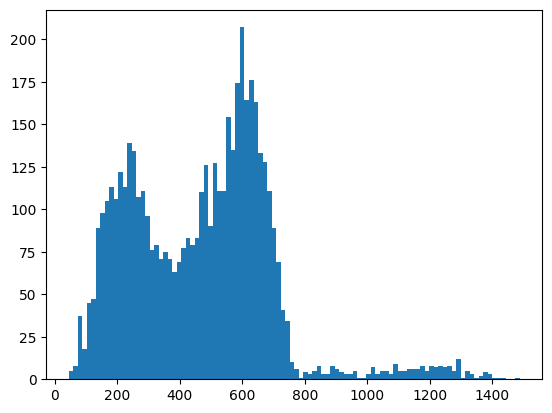

In [26]:
from matplotlib import pyplot as plt
plt.hist(lengths, bins=100)
plt.show()

In [34]:
# compute percentiles
np.percentile(lengths, 92)

703.0